In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Importing Excel Data
xls = "HP_data.xlsx"
df = pd.read_excel(xls)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head(10)

/Users/kelstonchen/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,HPL,CPI,HDII,HDI,GINI_TAX,GINI_ADJ,USER_COST,UR,HSTOCK,SLOS
Date,,,,,,,,,,
1990-01-01,156088,0.66,424894,403280,0.29,0.32,9.81,7.63,5400744,38.60
1990-04-01,148973,0.66,424992,392652,0.29,0.33,12.02,7.67,5606072,38.60
1990-07-01,153420,0.67,429362,404988,0.29,0.33,12.21,8.17,5484717,32.77
1990-10-01,151196,0.68,432824,412232,0.29,0.33,11.29,9.13,5697854,38.45
1991-01-01,156088,0.69,435056,417232,0.29,0.33,7.74,10.17,5642785,26.65
1991-04-01,164537,0.70,444503,412040,0.29,0.33,7.18,10.33,5404971,12.57
1991-07-01,158311,0.70,449692,420200,0.29,0.33,7.66,10.43,5681110,11.52
1991-10-01,157422,0.70,451028,424068,0.29,0.33,7.26,10.33,5798660,10.08
1992-01-01,159201,0.70,452309,419928,0.29,0.33,9.68,10.60,5838794,5.01


# Error Correction Model

This is the error correction model:
$$\Delta ln (\frac {p^H_t} {Y_t}) = a_0 - a_1 [ln(\frac {p^H_{t-1}} {Y_{t-1}}) - \frac {a_2} {a_1} (r_t + \delta_t + \tau_t) - \frac {a_3} {a_1} ln H_{t-1}] + \sum \limits_{i=1}^n b_i z_t$$

However, this model can be simplified into an OLS:

$$\Delta ln (\frac {p^H_t} {Y_t}) = a_0 - a_1 ln(\frac {p^H_{t-1}} {Y_{t-1}}) - {a_2} (r_t + \delta_t + \tau_t) - {a_3} ln H_{t-1} + \sum \limits_{i=1}^n b_i z_t$$

* $\frac {p^H_t} {Y_t}$: is our house price to income ratio

* $r_t + \delta_t + \tau_t$: is our user cost, which consists of the interest rate $(r)$, depreciation rate $(\delta)$, and property tax rate $(\tau)$

* $H_{t-1}$: is our housing stock

* $\sum \limits_{i=1}^n b_i z_t$: covers all of our shock variables $(z)$ and its corresponding coefficient $(b)$

# The Variables

Here we will be creating all of the necessary variables used in the Error Correction model shown above.

In [3]:
# Describing the variables for the regression
df["lnPY"] = np.log(df["HPL"] / df["HDII"])

# Endogenous variable
df["ΔlnPY"] = df["lnPY"].diff(1)

# Equilibrium variables
df["lnPY_lag"] = df["lnPY"].shift(1)
df["UserCost_lag"] = df["USER_COST"].shift(1)
df["lnHstock_lag"] = np.log(df["HSTOCK"].shift(1))

# Shocks
df["ΔlnRealHDII"] = np.log(df["HDII"] / df["CPI"]).diff(1)
df["ΔlnPY_lag"] = df["lnPY_lag"].diff(1)
df["ΔlnHstock_lag"] = df["lnHstock_lag"].diff(1)
df["ΔlnGiniAdj"] = np.log(df["GINI_ADJ"]).diff(1)
df["ΔSLOS"] = df["SLOS"].diff(1)

df1 = df.dropna()

## Regression with limited dates (1990Q3 - 2019Q4)

With the lack of data after the events of Covid-19 so far, we will limit the data to 2019Q4. This will be done because we do not want the extreme outcomes of Covid to dramatically affect the results of our OLS regression.

This will lead to more reliable results for our estimation.

In [4]:
# Testing the regression with only going up to 2019 Q4
limit_date = df1.loc["1990Q3":"2019Q4"]
# limit_date.to_excel("Simulation_Data.xlsx")
limit_date

,HPL,CPI,HDII,HDI,GINI_TAX,GINI_ADJ,USER_COST,UR,HSTOCK,SLOS,lnPY,ΔlnPY,lnPY_lag,UserCost_lag,lnHstock_lag,ΔlnRealHDII,ΔlnPY_lag,ΔlnHstock_lag,ΔlnGiniAdj,ΔSLOS
Date,,,,,,,,,,,,,,,,,,,,
1990-07-01,153420,0.67,429362,404988,0.29,0.33,12.21,8.17,5484717,32.77,-1.029121,0.019184,-1.048305,12.02,15.539361,-0.004808,-0.046885,0.037314,0.0,-5.83
1990-10-01,151196,0.68,432824,412232,0.29,0.33,11.29,9.13,5697854,38.45,-1.051754,-0.022633,-1.029121,12.21,15.517476,-0.006784,0.019184,-0.021885,0.0,5.68
1991-01-01,156088,0.69,435056,417232,0.29,0.33,7.74,10.17,5642785,26.65,-1.025055,0.026699,-1.051754,11.29,15.555600,-0.009455,-0.022633,0.038124,0.0,-11.80
1991-04-01,164537,0.70,444503,412040,0.29,0.33,7.18,10.33,5404971,12.57,-0.993821,0.031233,-1.025055,7.74,15.545888,0.007093,0.026699,-0.009712,0.0,-14.08
1991-07-01,158311,0.70,449692,420200,0.29,0.33,7.66,10.43,5681110,11.52,-1.044001,-0.050180,-0.993821,7.18,15.502830,0.011606,0.031233,-0.043059,0.0,-1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,574545,1.04,1268753,1244536,0.30,0.34,3.60,5.80,9711319,-15.98,-0.792211,0.015690,-0.807901,3.55,16.116765,-0.011036,0.006287,-0.016055,0.0,-5.04
2019-01-01,576769,1.05,1284852,1253808,0.30,0.34,3.66,5.87,9951460,-2.67,-0.800957,-0.008746,-0.792211,3.60,16.088803,0.003040,0.015690,-0.027963,0.0,13.31
2019-04-01,572767,1.05,1314230,1279508,0.30,0.34,3.09,5.60,10262513,-5.76,-0.830527,-0.029570,-0.800957,3.66,16.113230,0.022607,-0.008746,0.024427,0.0,-3.09


In [5]:
# Note: I added ΔSLOS back into this regresison, not significant but the coefficient makes sense.
reg_limit = smf.ols("ΔlnPY ~ lnPY_lag + UserCost_lag + lnHstock_lag + ΔlnPY_lag + ΔlnHstock_lag + ΔlnRealHDII + ΔlnGiniAdj + ΔSLOS + UR", data=limit_date)
results_limit = reg_limit.fit()
print(results_limit.summary())

                            OLS Regression Results                            
Dep. Variable:                  ΔlnPY   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     9.325
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           2.26e-10
Time:                        09:59:48   Log-Likelihood:                 360.68
No. Observations:                 118   AIC:                            -701.4
Df Residuals:                     108   BIC:                            -673.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5129      0.268      1.911

# Dynamic Estimation

Now lets see how the model compares to the actual data through a dynamic estimation model.

The procedure for the dynamic model is spelled out below.

<!-- 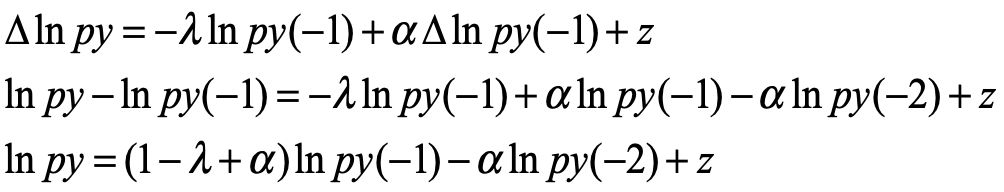 -->

 $$\Delta ln \frac{P^H_t} {Y_{t}} = -\lambda ln \frac{P^H_{t-1}} {Y_{t-1}} + \alpha \Delta ln \frac{P^H_{t-1}} {Y_{t-1}} + \sum \limits_{i=1}^n b_i z_t$$

If we let $\frac{P^H_t} {Y_{t}} = py$:

$$\Delta ln (py) = -\lambda ln (py)_{t-1} + \alpha \Delta ln (py)_{t-1} + \sum \limits_{i=1}^n b_i z_t$$

$$ln (py) - ln (py)_{t-1} = \lambda ln (py)_{t-1} + \alpha ln (py)_{t-1} - \alpha ln (py)_{t-2} + \sum \limits_{i=1}^n b_i z_t$$

 $$ ln (py) = (1 - \lambda + \alpha) ln (py)_{t-1} - \alpha ln (py)_{t-2} + \sum \limits_{i=1}^n b_i z_t$$

In [6]:
# Showing the parameters given from the OLS regression
a = results_limit.params
print(a)

Intercept        0.512860
lnPY_lag        -0.035490
UserCost_lag    -0.003522
lnHstock_lag    -0.031368
ΔlnPY_lag        0.776966
ΔlnHstock_lag    0.735328
ΔlnRealHDII     -0.683523
ΔlnGiniAdj      -0.267641
ΔSLOS           -0.000051
UR              -0.003252
dtype: float64


## Generating the Dynamic Model

In [7]:
# Here we are going to create the dynamic model..
# First, the coefficients that we will use on our Dependent and lagged dependent variable in our dynamic estimation procedure
coeff = 1 + a[1] + a[4]
α1 = -a[4]

In [8]:
# Defining the function for dynamic estimation
def dynamic_est(df, UserCost, actual_data):
    
    # Creating a vector to hold the house prices
    house_prices = []
    
    # Running the dynamic estimation
    for i in range(len(df)):
        if i < actual_data:
            house_prices.append(df.iloc[i]['lnPY'])
            continue
        new_house_price = a[0]
        new_house_price += coeff * house_prices[i-1]
        new_house_price += α1 * house_prices[i-2]
        new_house_price += a[2] * df.iloc[i][UserCost]
        new_house_price += a[3] * df.iloc[i]['lnHstock_lag']
        new_house_price += a[5] * df.iloc[i]['ΔlnHstock_lag']
        new_house_price += a[6] * df.iloc[i]['ΔlnRealHDII']
        new_house_price += a[7] * df.iloc[i]['ΔlnGiniAdj']
        new_house_price += a[8] * df.iloc[i]['ΔSLOS']
        new_house_price += a[9] * df.iloc[i]['UR']
        house_prices.append(new_house_price)
    return house_prices

In [9]:
# Running the dynamic model created above
house_prices = dynamic_est(limit_date, 'UserCost_lag', 2)

# Predicted House Prices
pred_hp = np.log(np.exp(house_prices) * limit_date['HDII'] / limit_date['CPI'])

# Actual House Prices
actual_hp = np.log(limit_date['HPL'] / limit_date['CPI'])

Text(0.5, 1.0, 'Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)')

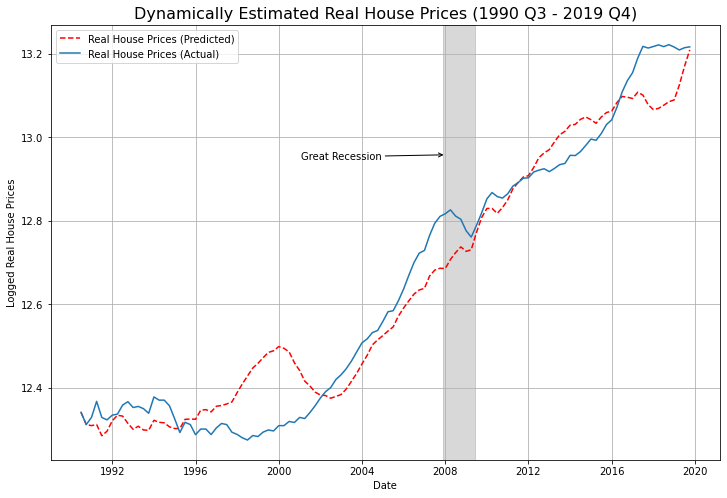

In [43]:
# Plotting the data
fig, ax = plt.subplots(figsize=(12, 8))

# plotting house price lines
ax.plot(limit_date.index, pred_hp, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(limit_date.index, actual_hp, label="Real House Prices (Actual)")

ax.annotate(text='Great Recession', xy=(395, 305), xytext=(250, 300), xycoords='axes points',
           arrowprops=dict(arrowstyle='->'))

# great recession shade
ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')
ax.grid()
ax.legend()
ax.set_title('Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)', fontsize='16')

## Adjusting the model

Lets try to fit the model better, by starting the estimation at a later date.

The data seems to become unsettled between 1998-2003, so lets start the estimation at 1999 instead.

In [63]:
# Adjusting the Estimation so that it starts at a later date [37 == 1999-10-01]
house_prices_re = dynamic_est(limit_date, 'UserCost_lag', 37)

In [64]:
# Predicted House Prices
pred_hp_re = np.log(np.exp(house_prices_re) * limit_date['HDII'] / limit_date['CPI'])

Text(0.5, 1.0, 'Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)')

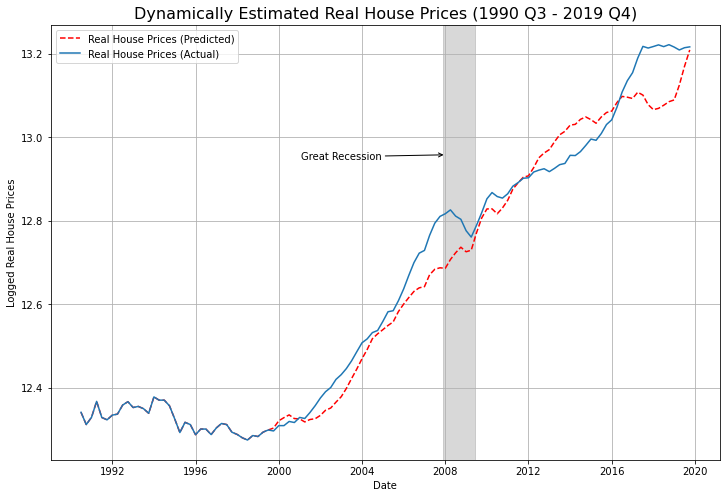

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(limit_date.index, pred_hp_re, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(limit_date.index, actual_hp, label="Real House Prices (Actual)")

ax.annotate(text='Great Recession', xy=(395, 305), xytext=(250, 300), xycoords='axes points',
           arrowprops=dict(arrowstyle='->'))

ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')
ax.grid()
ax.legend()
ax.set_title('Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)', fontsize='16')

## User Cost Analysis

Lets see how an increase in user cost, either through hikes in the interest rate or a rise in property taxes, affects real house price levels in Canada. 

To do this we will look at 2 Scenarios:
   
1. An increase in the User Cost by 100 basis points (bps)

2. An increase in the User Cost by 200 bps

To show how the user cost can affect housing prices, lets assume the the central bank, or policy makers, are fully aware of the housing bubble arising, and they are stringent on doing something to stop it. In other words lets assume that the central bank will employ macro-prudential policy. In doing so, the policy rate, or property taxes, will increase in periods 2005 - 2009, and settle back to actual levels afterwards (2010-2019). 

In the first and second scenario, the interest rates will rise by 1% and 2% respectively.

In [50]:
pre = limit_date.loc['1990':'2004', 'UserCost_lag']
hike = limit_date.loc['2005':'2009', 'UserCost_lag']
post = limit_date.loc['2010':, 'UserCost_lag']

# policy hikes to stop housing bubble, then returns to normal
macro_prud = pd.concat([pre, hike+1, post])
macro_prud_agg = pd.concat([pre, hike+2, post])

limit_date['macro_prud'] = macro_prud
limit_date['macro_prud_agg'] = macro_prud_agg

/var/folders/97/wqpkg6153sbcnm16py00_sl80000gn/T/ipykernel_97518/2981112937.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limit_date['macro_prud'] = macro_prud
/var/folders/97/wqpkg6153sbcnm16py00_sl80000gn/T/ipykernel_97518/2981112937.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limit_date['macro_prud_agg'] = macro_prud_agg


In [15]:
est_prudent_policy = dynamic_est(limit_date, 'macro_prud', 37)
est_prudent_policy_agg = dynamic_est(limit_date, 'macro_prud_agg', 37)

pred_prudent_hp = np.log(np.exp(est_prudent_policy) * limit_date['HDII'] / limit_date['CPI'])
pred_prudent_hp_agg = np.log(np.exp(est_prudent_policy_agg) * limit_date['HDII'] / limit_date['CPI'])

Text(0.5, 1.0, 'Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)')

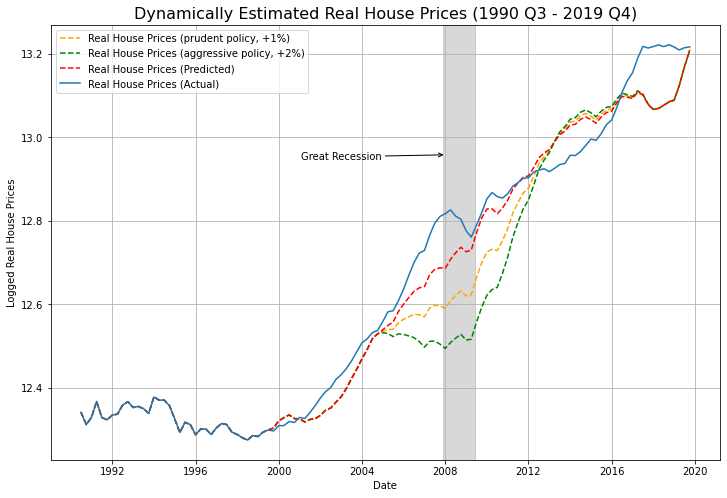

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))

# plotting the house prices lines
ax.plot(limit_date.index, pred_prudent_hp, label="Real House Prices (prudent policy, +1%)", c='orange', linestyle='--')
ax.plot(limit_date.index, pred_prudent_hp_agg, label="Real House Prices (aggressive policy, +2%)", c='green', linestyle='--')
ax.plot(limit_date.index, pred_hp_re, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(limit_date.index, actual_hp, label="Real House Prices (Actual)")

# great recession shade
ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3)

ax.annotate(text='Great Recession', xy=(395, 305), xytext=(250, 300), xycoords='axes points',
           arrowprops=dict(arrowstyle='->'))

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.grid()
ax.legend()
ax.set_title('Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)', fontsize='16')

# Extending the model to 2021 Q3

In [17]:
# Re-estimating the model with the longer time frame
HPL_2021 = dynamic_est(df1, 'UserCost_lag', 37)

# Predicted and actual data points
pred_2021 = np.log(np.exp(HPL_2021) * df1['HDII'] / df1['CPI'])
actual_2021 = np.log(df1['HPL'] / df1['CPI'])

Text(0.5, 1.0, 'Dynamically Estimated Real House Prices (1990 Q3 - 2021 Q3)')

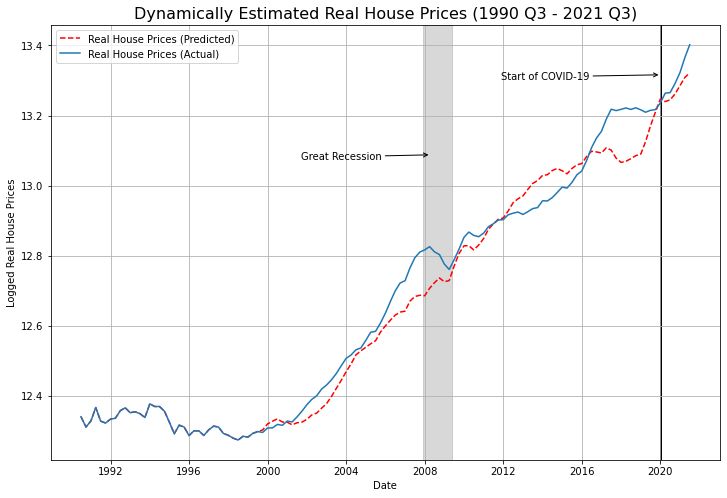

In [47]:
# Plotting 
fig, ax = plt.subplots(figsize=(12, 8))

# plotting lines
ax.plot(df1.index, pred_2021, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(df1.index, actual_2021, label="Real House Prices (Actual)")
# great recession
ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3)
# COVID
ax.axvspan('2020-01-01', '2020-01-15', color='black')

ax.annotate(text='Great Recession', xy=(380, 305), xytext=(250, 300), xycoords='axes points',
           arrowprops=dict(arrowstyle='->'))

ax.annotate(text='Start of COVID-19', xy=(610, 385), xytext=(450, 380), xycoords='axes points',
           arrowprops=dict(arrowstyle='->'))

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.grid()
ax.legend()
ax.set_title('Dynamically Estimated Real House Prices (1990 Q3 - 2021 Q3)', fontsize='16')

## User Cost analysis including 2021

Lets see how the model looks when policy makers attack housing prices during the Great recession and during COVID-19.

In this case, policy makers increase interest rates, or property tax rates, by 1% to impede the 2008 housing bubble, and increase interest rates by 2% at the start of 2021 to put the brakes on inflation. 

In [19]:
# Creating scenarios of higher interest rates/property tax rates
pre_21 = df1.loc['1990':'2004', 'UserCost_lag']
hike_21 = df1.loc['2005':'2008', 'UserCost_lag']
post_21 = df1.loc['2009':'2020', 'UserCost_lag']
covid_policy = df1.loc['2021':, 'UserCost_lag']

# policy to attack both 2008 and the inflation period of COVID
macro_prud_21 = pd.concat([pre_21, hike_21+1, post_21, covid_policy+2])
# strict macro-prudential policy, increased user cost from 2009 until 2021
macro_prud_21_strict = pd.concat([pre_21, hike_21+1, post_21+1, covid_policy+2])

df1['macro_prud_21'] = macro_prud_21
df1['macro_prud_21_strict'] = macro_prud_21_strict

/var/folders/97/wqpkg6153sbcnm16py00_sl80000gn/T/ipykernel_97518/3122840290.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['macro_prud_21'] = macro_prud_21
/var/folders/97/wqpkg6153sbcnm16py00_sl80000gn/T/ipykernel_97518/3122840290.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['macro_prud_21_strict'] = macro_prud_21_strict


In [20]:
est_policy_21 = dynamic_est(df1, 'macro_prud_21', 37)
est_policy_strict = dynamic_est(df1, 'macro_prud_21_strict', 37)

pred_prud_hp_21 = np.log(np.exp(est_policy_21) * df1['HDII'] / df1['CPI'])
pred_prud_hp_strict = np.log(np.exp(est_policy_strict) * df1['HDII'] / df1['CPI'])

Text(0.5, 1.0, 'Dynamically Estimated Real House Prices (1990 Q3 - 2021 Q3)')

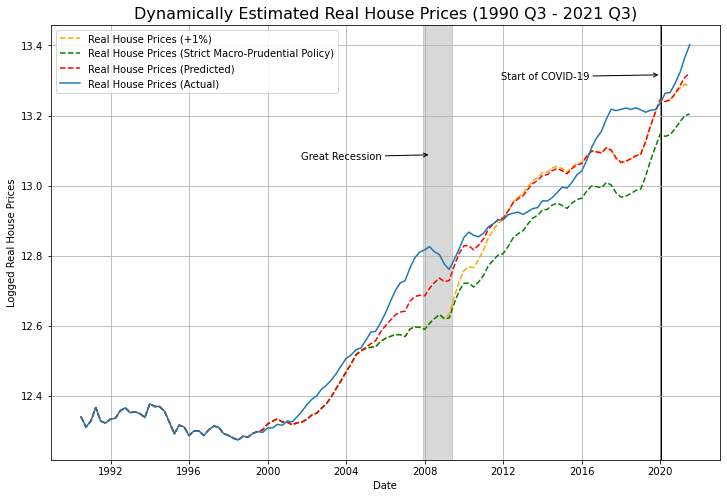

In [49]:
# Plotting 
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df1.index, pred_prud_hp_21, label="Real House Prices (+1%)", c='orange', linestyle='--')
ax.plot(df1.index, pred_prud_hp_strict, label="Real House Prices (Strict Macro-Prudential Policy)", c='green', linestyle='--')
ax.plot(df1.index, pred_2021, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(df1.index, actual_2021, label="Real House Prices (Actual)")

ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3)
ax.axvspan('2020-01-01', '2020-01-15', color='black')

ax.annotate(text='Great Recession', xy=(380, 305), xytext=(250, 300), xycoords='axes points',
           arrowprops=dict(arrowstyle='->'))

ax.annotate(text='Start of COVID-19', xy=(610, 385), xytext=(450, 380), xycoords='axes points',
           arrowprops=dict(arrowstyle='->'))

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.grid()
ax.legend()
ax.set_title('Dynamically Estimated Real House Prices (1990 Q3 - 2021 Q3)', fontsize='16')
# plt.savefig("Dynamic HPL", dpi=300, facecolor="white")